In [1]:
##Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter

#Lets import the trtaining data 


In [2]:
training_data = pd.read_csv('./alphaseq_data_train.csv')
sample = training_data[:300]
print(training_data.head())
print('___________________')
print(training_data.describe())
print('___________________')
print(str(training_data.shape[0]) + '  rows' + ', ' + str(training_data.shape[1]) + '  columns')

#Check for missing values
missing_kd = training_data['Kd'].isnull().sum()
missing_q = training_data['q_value'].isnull().sum()
if missing_kd:
    print('There are ' + str(missing_kd) + ' missing values in the Kd column')
if missing_q:
    print('There are ' + str(missing_q) + ' missing values in the q column')

#Create a new potential feature -> the difference in bounds for Kd_lower_bound and Kd_upper_bound
training_data['Kd_bound_diff'] = training_data['Kd_upper_bound'] - training_data['Kd_lower_bound']



  description_a                                         sequence_a  \
0          WT_0  QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLE...   
1          WT_1  QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLE...   
2         WT_10  QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLE...   
3         WT_11  QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLE...   
4         WT_12  QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLE...   

    description_alpha                                     sequence_alpha  \
0  huPD-1_RE(rebuilt)  LDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRM...   
1  huPD-1_RE(rebuilt)  LDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRM...   
2  huPD-1_RE(rebuilt)  LDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRM...   
3  huPD-1_RE(rebuilt)  LDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRM...   
4  huPD-1_RE(rebuilt)  LDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRM...   

         Kd  Kd_lower_bound  Kd_upper_bound  q_value  
0  1.241963        1.191959        1.291968      0.0  
1  1.379355 

### Lets do some data exploration and feature generation 

1) We'll start with an exploration of the Kd values. Key points we're looking for: 
    - Are there outlier sequences where the Kd ratio significantly outside the norm?
        - Mark them with a row based label - "outlier"
    - How wide is the bound_diff between upper_bound and lower_found Kd values? 
        - What does it meant if the bound_diff is very large?
2) After that, we'll take a look at the sequences. We want to understand
    - Are there length trends?
    - Are there trends in the frequency of amino acids?
    - What is the relationship of description_a to sequence_a and description_alpha to sequence_alpha
    - We should expect the following new features to come out of this analysis:
        - sequence length for sequence_a and sequence_alpha
        - Amino Acid distribution for sequence_a and sequence_alpha
3) Next, we'll move on correlation analyses. Is there a correlation between the Kd values and the sequences, descriptors, or even the amino acids found within the training data?
    - 

In [3]:
#Lets create a function that shows us the distribution of any continuous variable within the data
#Bins is calculated by using Scott's Rule: bins = int((3.5 * np.std(data[column])) / (len(data[column])**(1/3)))

def histogram_plot_distribution(data, column, bins_manual):
    
    #print(np.std(data[column]), '--- std')
    iqr = data[column].quantile(0.75) - data[column].quantile(0.25)
    #print(iqr, '  ---- IQR ')
    bins = (2*iqr)/(len(data[column])**(1/3))
    #print(bins, ' ---- number of suggested bins using Freedman - Diaconis Rule')
    
    if int(bins) > 10:
        data[column].hist(bins=bins).set_title('Distribution of ' + column + ' values for the training data')
    elif isinstance(bins_manual, int):
        print('we used manual bins')
        bins = bins_manual
        data[column].hist(bins=bins).set_title('Distribution of ' + column + ' values for the training data')
    
    else:
        print('we used manual bins')
        bins = 400
        data[column].hist(bins=bins).set_title('Distribution of ' + column + ' values for the training data')
    
    plt.xlabel(column +' values')
    plt.ylabel('Frequency')
    
    return plt.show()

def boxplot_distribution_outlier_analysis(data, column):
    ax = sns.boxplot(x=data[column])
    ax.set_title('Box plot: Distribution of ' + column + ' values for the training data')
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_whisker = q1-1.5*iqr
    upper_whisker = q3+1.5*iqr

    # Check if the whiskers are within the data range
    lower_whisker = max(lower_whisker, data[column].min())
    upper_whisker = min(upper_whisker, data[column].max())

    print('The lower whisker is at:', lower_whisker)
    print('The upper whisker is at:', upper_whisker)

    # Get the whisker values
     # Adding labels to the whiskers
    plt.annotate(f'{lower_whisker:.2f}', xy=(0, lower_whisker), xytext=(0, -20),
                 textcoords='offset points', ha='center', va='top', fontsize=10, color='blue')
    
    plt.annotate(f'{upper_whisker:.2f}', xy=(0, upper_whisker), xytext=(0, 20),
                 textcoords='offset points', ha='center', va='bottom', fontsize=10, color='blue')
    
    plt.draw()  # This ensures the plot is fully rendered before we display it
    plt.show()
    return lower_whisker, upper_whisker


we used manual bins


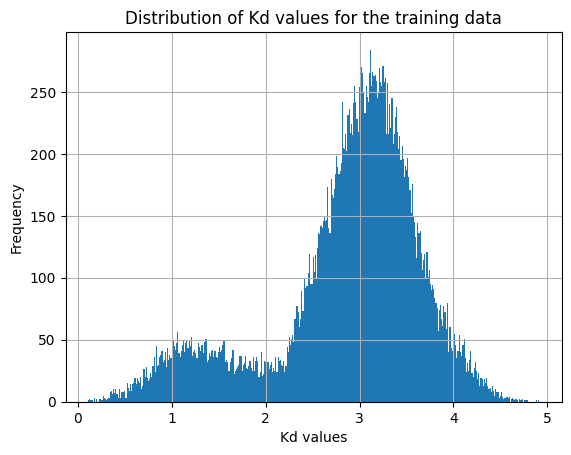

The lower whisker is at: 1.3860444686828233
The upper whisker is at: 4.586281318221826


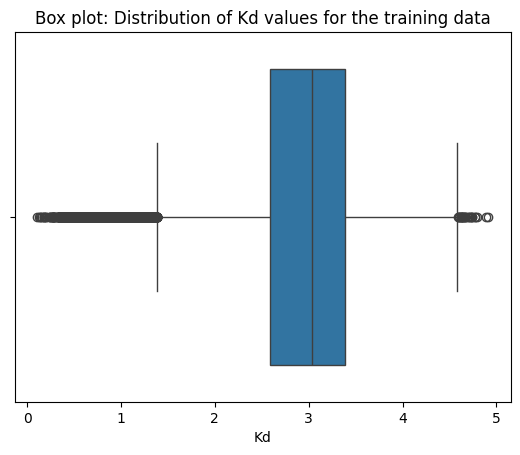

______________________________
we used manual bins


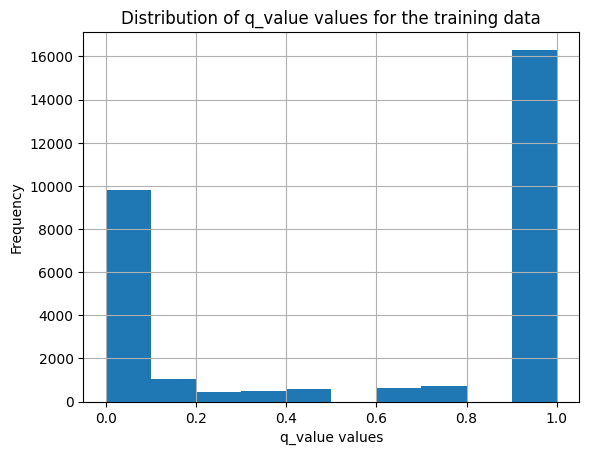

The lower whisker is at: 0.0
The upper whisker is at: 1.0


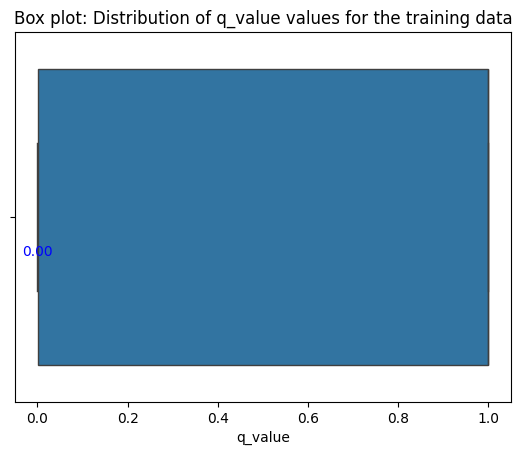

______________________________
we used manual bins


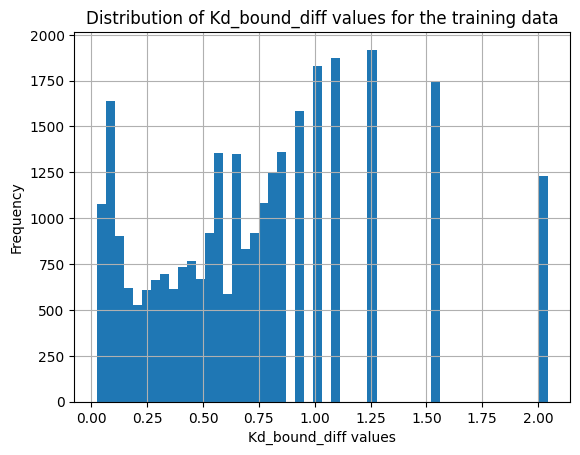

The lower whisker is at: 0.024935817688650275
The upper whisker is at: 1.9311771411491843


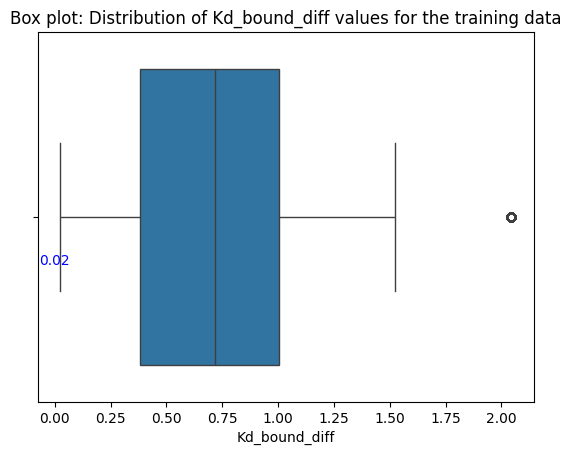

In [4]:
#Create first distribution plots and identify outliers
histogram_plot_distribution(data = training_data, column = 'Kd', bins_manual = 400)
kd_lower_whisker, kd_upper_whisker = boxplot_distribution_outlier_analysis(data = training_data, column = 'Kd')
print('______________________________')
histogram_plot_distribution(training_data, 'q_value', bins_manual = 10)
q_value_lower_whisker, q_value_upper_whisker = boxplot_distribution_outlier_analysis(data = training_data, column = 'q_value')
print('______________________________')
histogram_plot_distribution(training_data, 'Kd_bound_diff', bins_manual = 50)
kd_diff_lower_whisker, kd_diff_upper_whisker = boxplot_distribution_outlier_analysis(data = training_data, column = 'Kd_bound_diff')

In [5]:
training_data.head()

,description_a,sequence_a,description_alpha,sequence_alpha,Kd,Kd_lower_bound,Kd_upper_bound,q_value,Kd_bound_diff
0,WT_0,QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLE...,huPD-1_RE(rebuilt),LDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRM...,1.241963,1.191959,1.291968,0.0,0.100009
1,WT_1,QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLE...,huPD-1_RE(rebuilt),LDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRM...,1.379355,1.318349,1.440361,0.0,0.122012
2,WT_10,QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLE...,huPD-1_RE(rebuilt),LDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRM...,1.152859,1.120984,1.184735,0.0,0.063751
3,WT_11,QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLE...,huPD-1_RE(rebuilt),LDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRM...,1.123487,1.082745,1.164230,0.0,0.081485
4,WT_12,QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLE...,huPD-1_RE(rebuilt),LDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRM...,1.161713,1.128016,1.195410,0.0,0.067393


In [6]:
#Lets now label the datapoints within the training set that are Kd, q_value, or Kd_bound_diff outliers

#Number of Kd outliers
training_data['Kd_outlier'] = np.where((training_data['Kd'] < kd_lower_whisker) | (training_data['Kd'] > kd_upper_whisker), 1, 0)
print(len(training_data[training_data['Kd_outlier'] == 1]), '  Kd outliers')
print(len(training_data[training_data['Kd'] < kd_lower_whisker]), '  Kd lower whisker outliers')
print(len(training_data[training_data['Kd'] > kd_upper_whisker]), '  Kd upper whisker outliers')

print('____________________________')

#Number of q_value outliers
training_data['q_value_outlier'] = np.where((training_data['q_value'] < q_value_lower_whisker) | (training_data['q_value'] > q_value_upper_whisker), 1, 0)
print(len(training_data[training_data['q_value_outlier'] == 1]), ' q_value outliers')

print('____________________________')

#Number of Kd_bound_diff outliers
training_data['Kd_bound_diff_outlier'] = np.where((training_data['Kd_bound_diff'] < kd_diff_lower_whisker) | (training_data['Kd_bound_diff'] > kd_diff_upper_whisker), 1, 0)
print(len(training_data[training_data['Kd_bound_diff_outlier'] == 1]), 'k d_bound_diff outliers')
print(len(training_data[training_data['Kd_bound_diff'] < kd_diff_lower_whisker]), '  Kd_bound_diff lower whisker outliers')
print(len(training_data[training_data['Kd_bound_diff'] > kd_diff_upper_whisker]), '  Kd_bound_diff upper whisker outliers')

2552   Kd outliers
2526   Kd lower whisker outliers
26   Kd upper whisker outliers
____________________________
0  q_value outliers
____________________________
1231 k d_bound_diff outliers
0   Kd_bound_diff lower whisker outliers
1231   Kd_bound_diff upper whisker outliers


It seems that there are approximately 2552 Kd outliers and 1231 Kd_bound_diff outliers. The large majority of Kd outliers come from the lower bound whisker. This implies that these proteins may be especially well binding according to Kd meaning. 
All K_bound_diff outlier values are high outliers. This suggests that these are predictions where Kd has a larger level of uncertainty

In [7]:
#Lets check some counts. Are there duplicate descriptions or sequence_a?

unique_sequence_as = len(training_data['sequence_a'].unique())
unique_description_as = len(training_data['description_a'].unique())
unique_sequence_alpha = len(training_data['sequence_alpha'].unique())
unique_description_alpha = len(training_data['description_alpha'].unique())

print('____________________________')
print('There are ' + str(unique_description_as) + ' unique description_a')
print('There are ' + str(unique_sequence_as) + ' unique sequence_a')
print('There are ' + str(unique_sequence_alpha) + ' unique sequence_alpha')
print('There are ' + str(unique_description_alpha) + ' unique description_alpha')
print('____________________________')

#Count of sequence_a per description
description_a_grouped = training_data.groupby('description_a').count()
description_a_counts = description_a_grouped['sequence_a']
description_a_grouped.reset_index(inplace=True)
if any(description_a_counts > 1):
    print('There are ' + str(len(description_a_grouped[description_a_grouped > 1])) + ' description_a with more than 1 sequence_a')
    mult_seqs = description_a_grouped.loc[description_a_grouped['description_a'] > 1, 'sequence_a'].tolist()

sequence_a_grouped = training_data.groupby('sequence_a').count()
sequence_a_counts = sequence_a_grouped['description_a']
sequence_a_grouped.reset_index(inplace=True)
if any(sequence_a_counts > 1):
    print('There are ' + str(len(sequence_a_counts[sequence_a_counts > 1])) + ' sequence_a with more than 1 description')
    #Print out the sequence_as with more than 1 description
    mult_descs = sequence_a_grouped.loc[sequence_a_grouped['description_a'] > 1, 'sequence_a'].tolist()


#Lets mark the sequence_as with mutliple descriptions with a flag
training_data['multiple_desc_a'] = np.where(training_data['sequence_a'].isin(mult_descs), 1, 0)

____________________________
There are 30049 unique description_a
There are 29883 unique sequence_a
There are 1 unique sequence_alpha
There are 1 unique description_alpha
____________________________
There are 105 sequence_a with more than 1 description


## Sequence Analysis
- Now that we've marked the duplicates lets take a closer look at the sequences to see if we can find anything interesting. 


we used manual bins


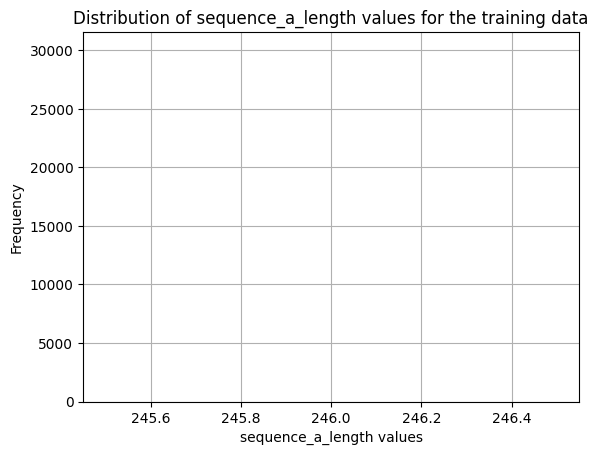

The lower whisker is at: 246.0
The upper whisker is at: 246.0


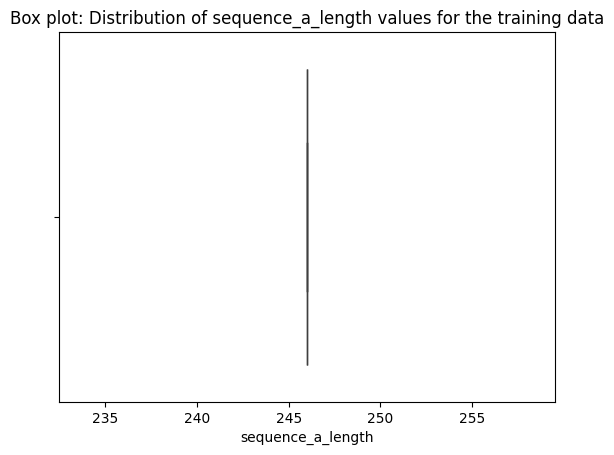

In [8]:
training_data['sequence_a_length'] = training_data['sequence_a'].apply(lambda x: len(x))

#Lets check the distribution of sequence_a lengths
histogram_plot_distribution(data = training_data, column = 'sequence_a_length', bins_manual = 400)
kd_lower_whisker, kd_upper_whisker = boxplot_distribution_outlier_analysis(data = training_data, column = 'sequence_a_length')

Ok, so that was a bit unexpected but it actually makes sense upon second thought! I initially assumed that we were looking at scFv variant of Pembrolizumabthat could differ in length but the instructions explicitly state that we are only looking at a window. The sequence_a values are all the same length because of the window

#Now lets look at the distribution of amino acids per variant



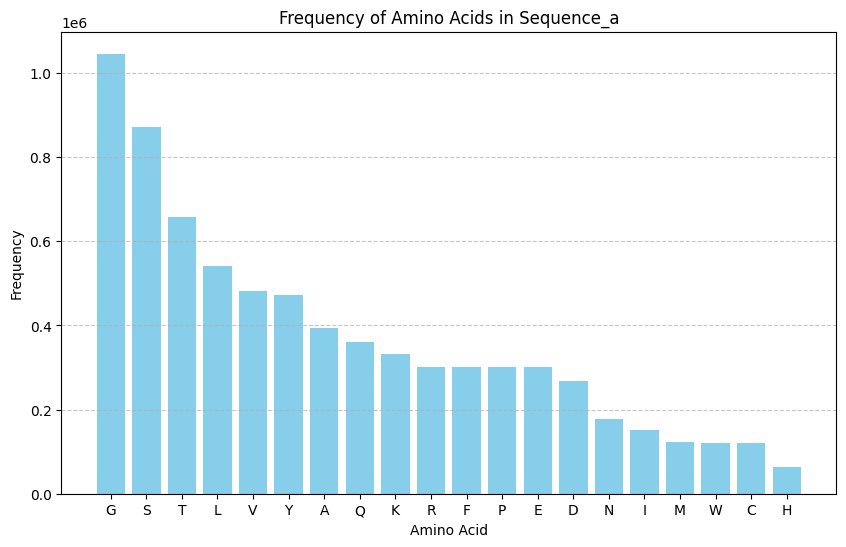

In [9]:
all_sequences_a = ''.join(training_data['sequence_a'])
all_amino_acids= Counter(all_sequences_a)

# Step 2: Create a DataFrame from the counter and plot
freq_df = pd.DataFrame(list(all_amino_acids.items()), columns=['Amino Acid', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(freq_df['Amino Acid'], freq_df['Frequency'], color='skyblue')
plt.title('Frequency of Amino Acids in Sequence_a')
plt.xlabel('Amino Acid')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Ok, so that provides a list of all the unique amino acids. It also tells us that that most of the AAs are G. This doesn't really tell us much because we can't see a correlation between the sum of the Amino Acids present and the Kd values (or really another numerical value.) I'm curious to see if we can turn the amino acid frequency into a feature that we can use in our models

In [10]:
list(all_amino_acids.keys())

def amino_acid_count(sequence, amino_acid):
    return sequence.count(amino_acid)

for aa in list(all_amino_acids.keys()):
    training_data[aa + ' counts'] = training_data['sequence_a'].apply(lambda x: amino_acid_count(x, aa))


In [11]:
training_data.columns

Index(['description_a', 'sequence_a', 'description_alpha', 'sequence_alpha',
       'Kd', 'Kd_lower_bound', 'Kd_upper_bound', 'q_value', 'Kd_bound_diff',
       'Kd_outlier', 'q_value_outlier', 'Kd_bound_diff_outlier',
       'multiple_desc_a', 'sequence_a_length', 'Q counts', 'V counts',
       'L counts', 'S counts', 'G counts', 'E counts', 'K counts', 'P counts',
       'A counts', 'C counts', 'Y counts', 'T counts', 'F counts', 'N counts',
       'M counts', 'W counts', 'R counts', 'I counts', 'D counts', 'H counts'],
      dtype='object')

We've created many new features. It's time to take a closer look at the correlation between these parameters. This should tell us what may be good features and what may not be good features. We can worry about the data selection later considering we still need to split the data and adjust for the numerous outliers. 

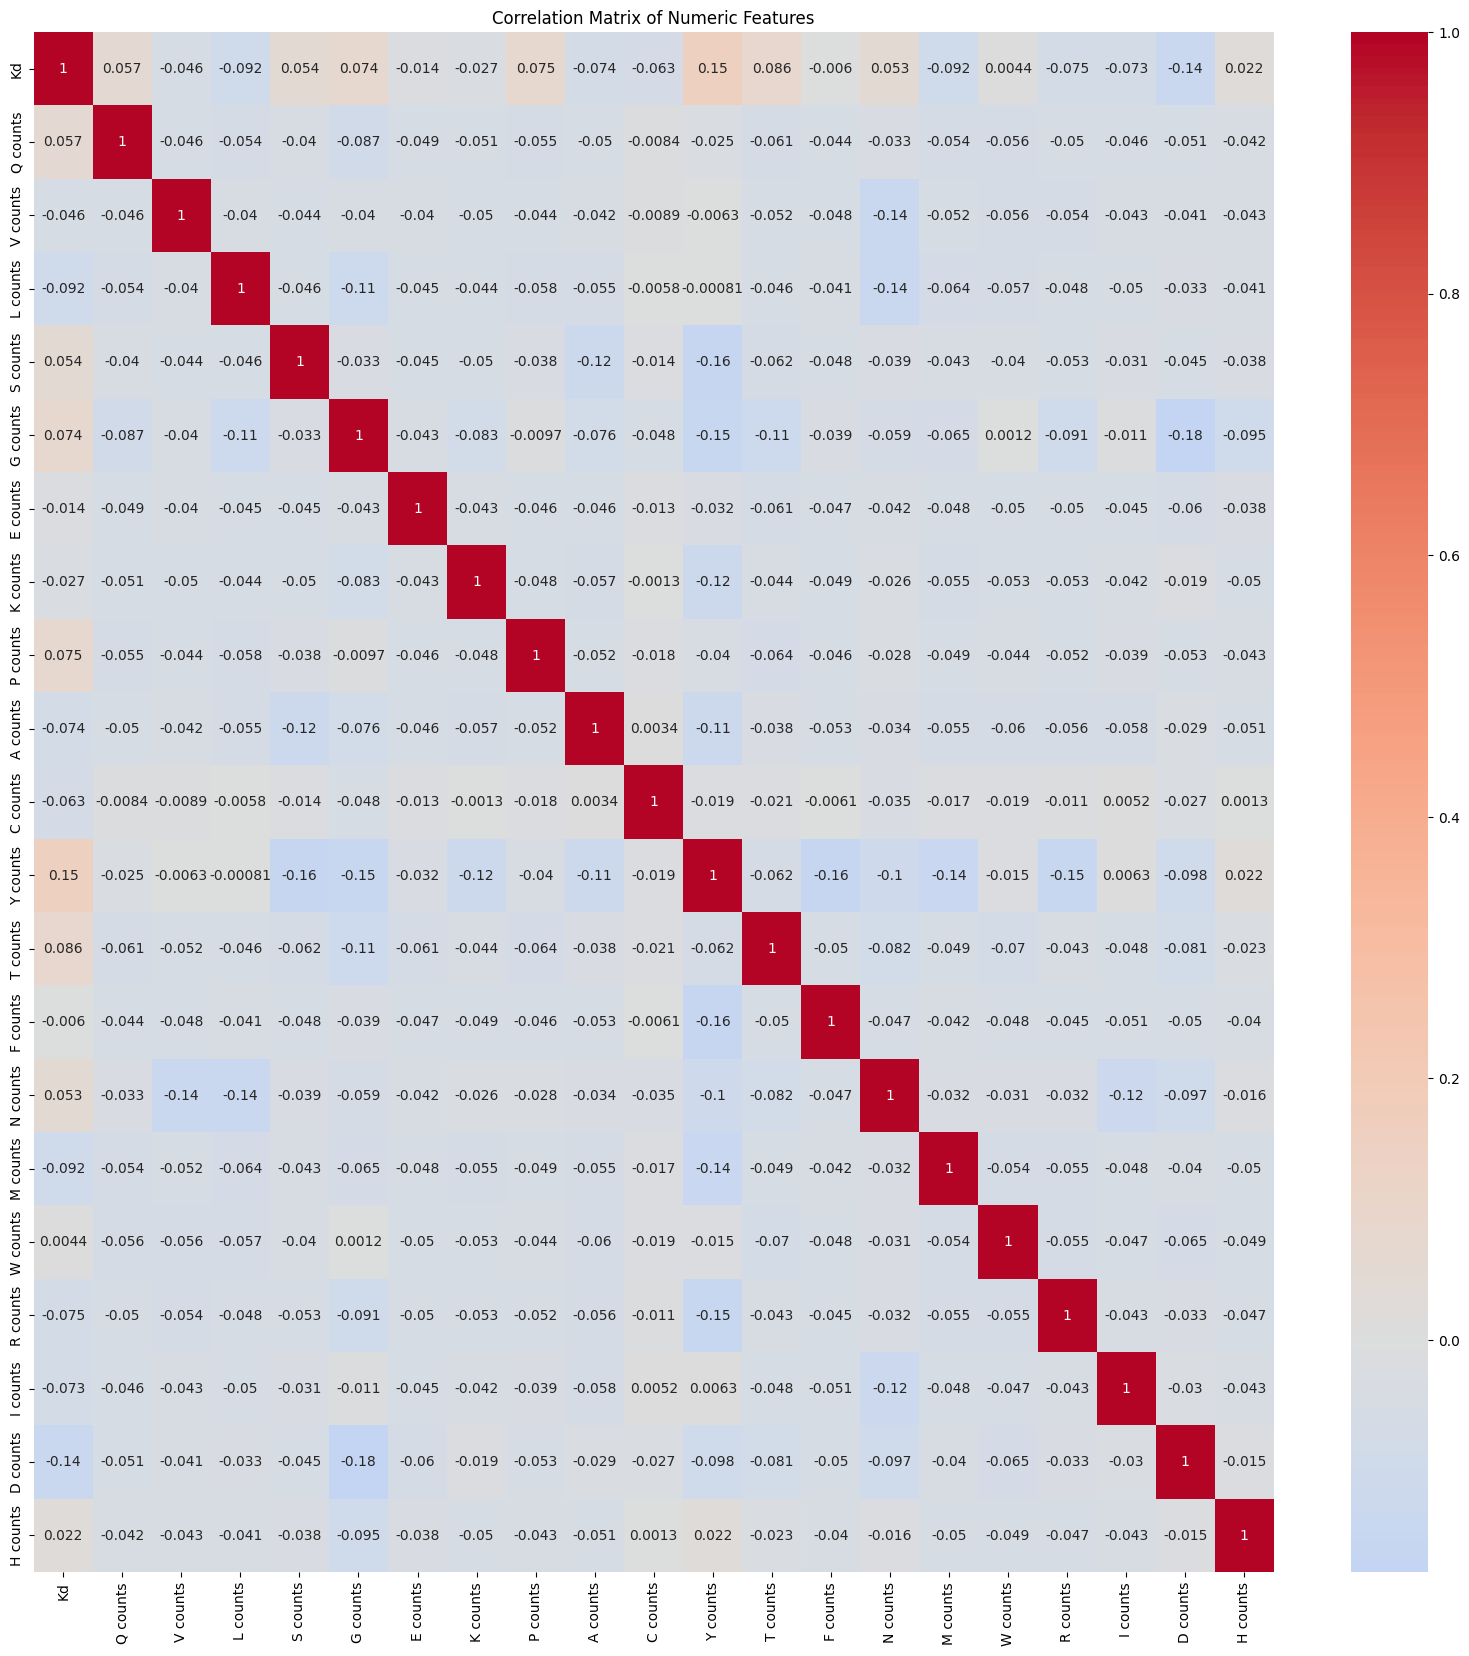

In [22]:
numeric_data = training_data[['Kd', 'Kd_lower_bound', 'Kd_upper_bound', 'q_value', 'Kd_bound_diff',
                            'Q counts', 'V counts', 'L counts', 'S counts', 'G counts', 'E counts', 'K counts', 'P counts',
                            'A counts', 'C counts', 'Y counts', 'T counts', 'F counts', 'N counts',
                            'M counts', 'W counts', 'R counts', 'I counts', 'D counts', 'H counts']]
numeric_data = training_data[['Kd',
                            'Q counts', 'V counts', 'L counts', 'S counts', 'G counts', 'E counts', 'K counts', 'P counts',
                            'A counts', 'C counts', 'Y counts', 'T counts', 'F counts', 'N counts',
                            'M counts', 'W counts', 'R counts', 'I counts', 'D counts', 'H counts']]

plt.figure(figsize = (20,20))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', center=0)

plt.title('Correlation Matrix of Numeric Features')
plt.show()

Based off of the analysis above it seems that many of the created features (particularly amino acid composition) are not correlated with other features. This suggests that they could be used for learning and colinearity is less likely to impact model generalizability. Nonlinear relationships are important - after all, we are still dealing with protein binding BUT it's not 

## Modelling Approaches
- We can experiment with using a protein language model (or some other method to translate these proteins into embeddings for use in our models)
- How do the established 